Mounted at /content/drive
✅ Using device: cpu
Loaded cube shape: (1088, 2048, 85)
Extracted 485 patches of size 64x64
Train: 388, Validation: 97


Epoch 1: 100%|██████████| 49/49 [32:31<00:00, 39.83s/it]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Epoch 1 Summary:
  Loss: 1.1257 | Accuracy: 73.20% | Precision: 65.78% | Recall: 73.20% | F1: 69.29%
💾 Saved checkpoint: /content/drive/MyDrive/HSI_RESULTS/checkpoint_epoch1_f169.29.pth
✅ Best model updated (F1=69.29%)


Epoch 2: 100%|██████████| 49/49 [29:57<00:00, 36.68s/it]



📊 Epoch 2 Summary:
  Loss: 0.6912 | Accuracy: 88.66% | Precision: 90.18% | Recall: 88.66% | F1: 87.55%
💾 Saved checkpoint: /content/drive/MyDrive/HSI_RESULTS/checkpoint_epoch2_f187.55.pth
✅ Best model updated (F1=87.55%)


Epoch 3: 100%|██████████| 49/49 [29:27<00:00, 36.08s/it]



📊 Epoch 3 Summary:
  Loss: 0.4493 | Accuracy: 98.97% | Precision: 98.98% | Recall: 98.97% | F1: 98.96%
💾 Saved checkpoint: /content/drive/MyDrive/HSI_RESULTS/checkpoint_epoch3_f198.96.pth
✅ Best model updated (F1=98.96%)


Epoch 4: 100%|██████████| 49/49 [29:37<00:00, 36.28s/it]



📊 Epoch 4 Summary:
  Loss: 0.2775 | Accuracy: 93.81% | Precision: 94.30% | Recall: 93.81% | F1: 93.54%
💾 Saved checkpoint: /content/drive/MyDrive/HSI_RESULTS/checkpoint_epoch4_f193.54.pth


Epoch 5: 100%|██████████| 49/49 [29:51<00:00, 36.56s/it]



📊 Epoch 5 Summary:
  Loss: 0.2155 | Accuracy: 90.72% | Precision: 91.77% | Recall: 90.72% | F1: 90.03%
💾 Saved checkpoint: /content/drive/MyDrive/HSI_RESULTS/checkpoint_epoch5_f190.03.pth

🎯 Training completed. Best F1-score: 98.9625696720906 %


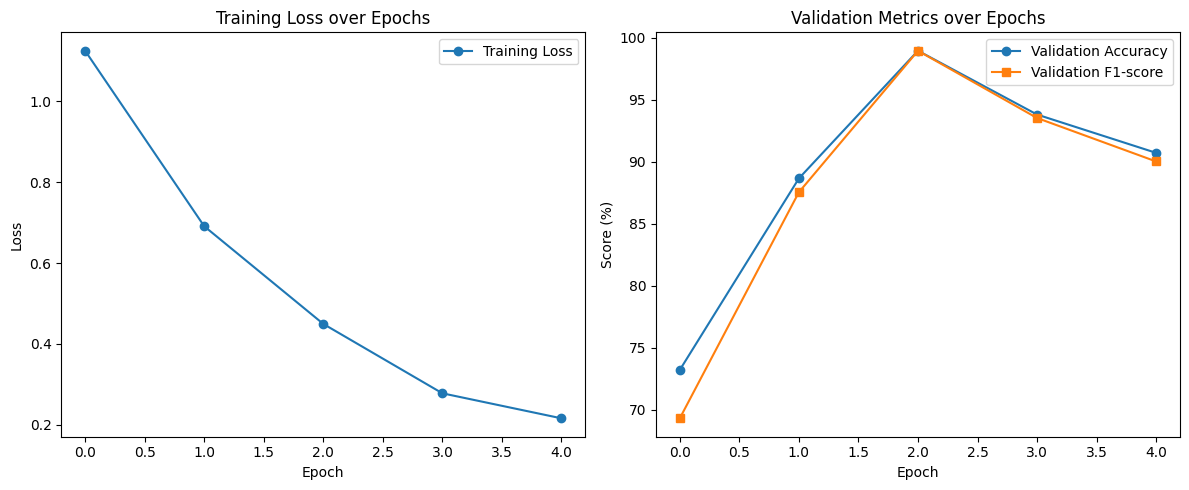


🩺 Predicted melanoma stage for sample #373: Stage II


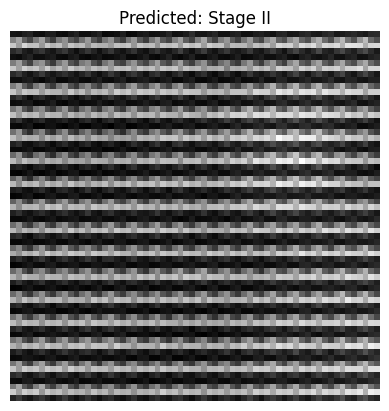

Epoch 5: Acc 90.72% | Prec 94.38% | Rec 82.69% | F1 86.55%


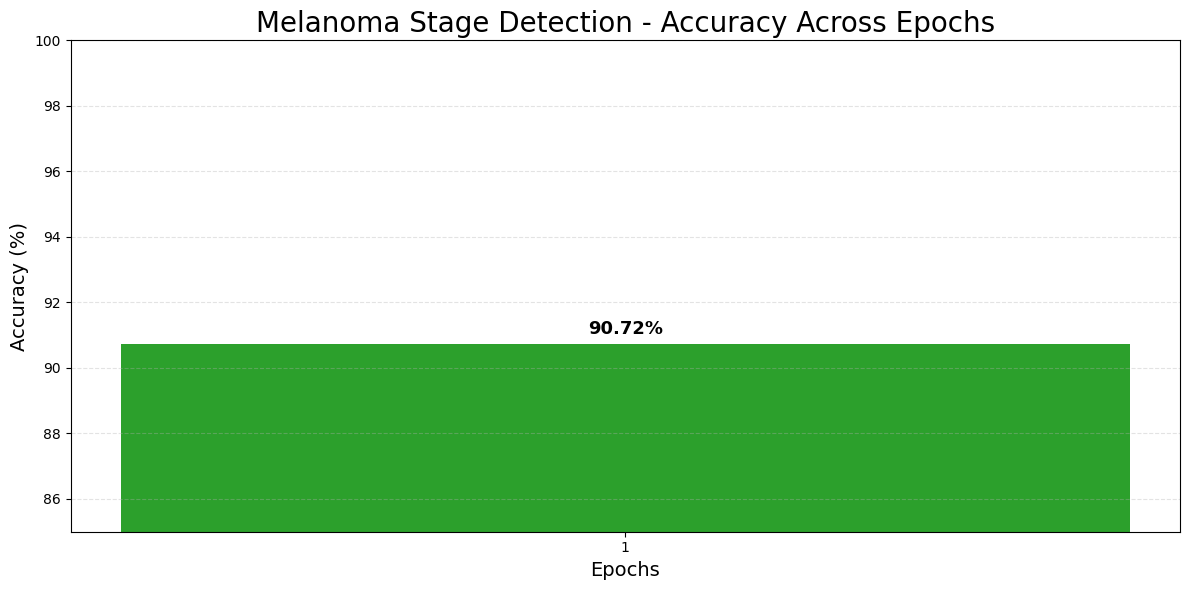

Saved: /content/drive/MyDrive/HSI_RESULTS/accuracy_across_epochs.png


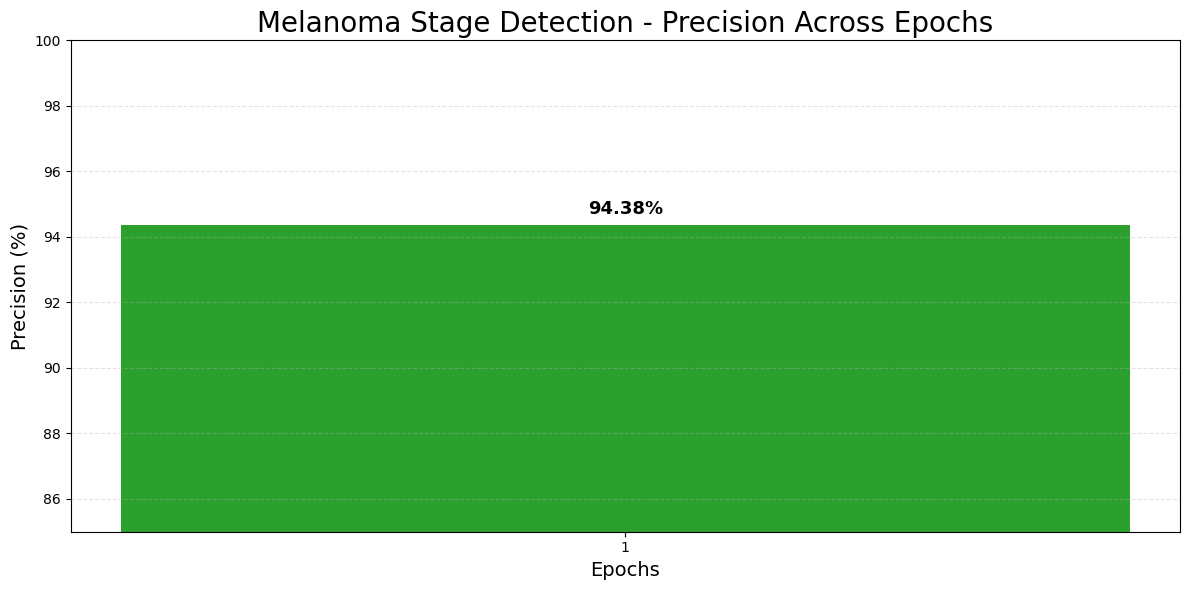

Saved: /content/drive/MyDrive/HSI_RESULTS/precision_across_epochs.png


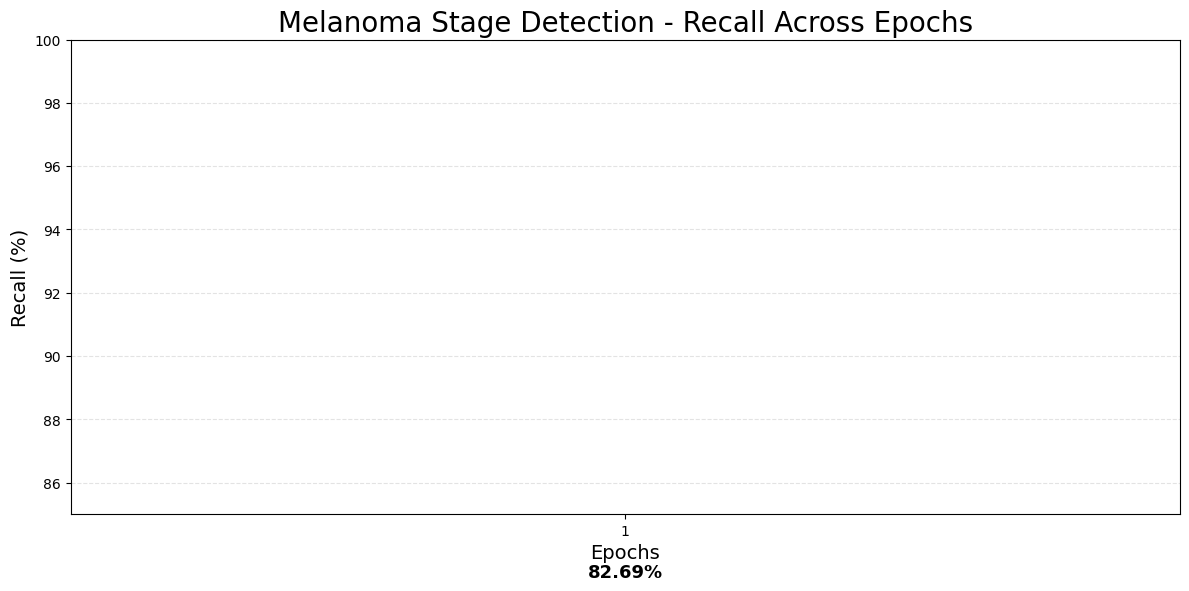

Saved: /content/drive/MyDrive/HSI_RESULTS/recall_across_epochs.png


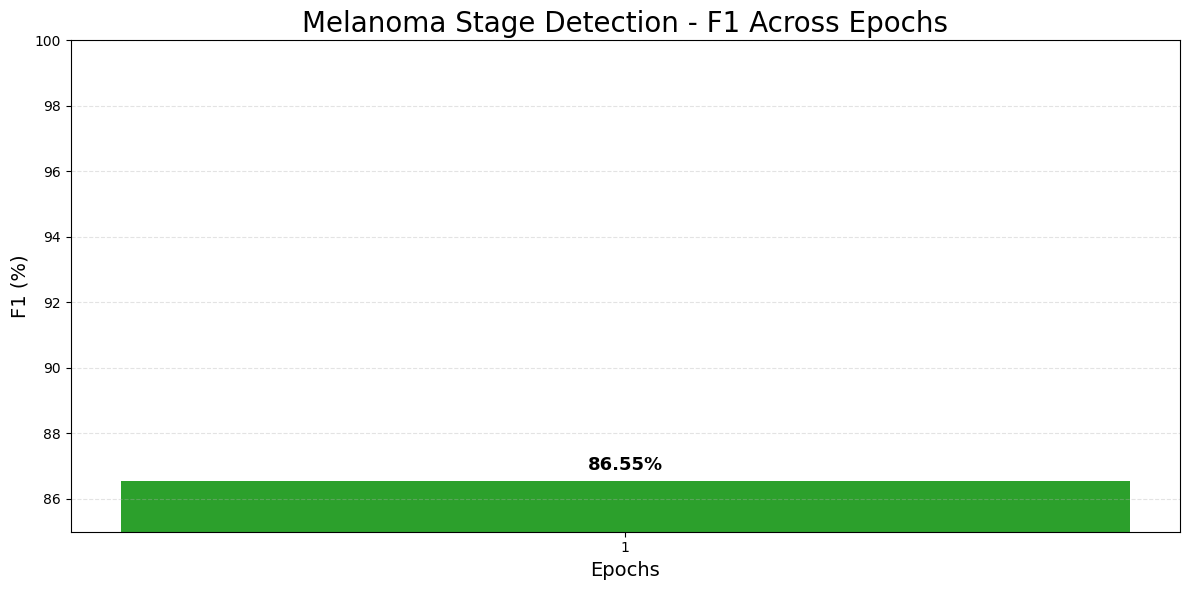

Saved: /content/drive/MyDrive/HSI_RESULTS/f1_across_epochs.png


In [ ]:
# ====== STEP 1: Environment Setup ======
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pip install -q torch torchvision torchaudio scikit-image tqdm scikit-learn matplotlib albumentations seaborn

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from skimage import io
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score
    )
import seaborn as sns
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)


# ====== STEP 2: Paths ======
DATA_DIR = "/content/drive/MyDrive/HSIDERMA/original_image/MM"
SAVE_DIR = "/content/drive/MyDrive/HSI_RESULTS"
os.makedirs(SAVE_DIR, exist_ok=True)
MODEL_PATH = os.path.join(SAVE_DIR, "best_unet_hsi.pth")


# ====== STEP 3: Load .bmp slices into a hyperspectral cube ======
def load_hsi_cube(folder_path):
    files = sorted([f for f in os.listdir(folder_path) if f.endswith('.bmp')])
    if len(files) == 0:
        raise ValueError("No .bmp files found in the folder!")

    slices = []
    for f in files:
        img = io.imread(os.path.join(folder_path, f)).astype(np.float32)
        if img.ndim == 3:
            img = np.mean(img, axis=-1)
        slices.append(img / 255.0)

    cube = np.stack(slices, axis=-1)
    print("Loaded cube shape:", cube.shape)
    return cube


# ====== STEP 4: Dataset ======
class MelanomaHSIDataset(Dataset):
    def __init__(self, cube_folder, patch_size=64):
        self.cube = load_hsi_cube(cube_folder)
        self.patch_size = patch_size
        self.samples = []
        self._prepare_patches()

    def _prepare_patches(self):
        H, W, B = self.cube.shape
        for i in range(0, H - self.patch_size, self.patch_size):
            for j in range(0, W - self.patch_size, self.patch_size):
                patch = self.cube[i:i+self.patch_size, j:j+self.patch_size, :]
                if patch.mean() > 0.05:
                    self.samples.append(patch)
        print(f"Extracted {len(self.samples)} patches of size {self.patch_size}x{self.patch_size}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        patch = self.samples[idx]
        patch = np.expand_dims(patch, axis=0)
        mean_val = patch.mean()
        if mean_val < 0.25:
            label = 0
        elif mean_val < 0.5:
            label = 1
        elif mean_val < 0.75:
            label = 2
        else:
            label = 3
        return torch.tensor(patch, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


# ====== STEP 5: 3D U-Net ======
class DoubleConv3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv3D, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)


class UNet3D(nn.Module):
    def __init__(self, n_classes=4):
        super(UNet3D, self).__init__()
        self.enc1 = DoubleConv3D(1, 16)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = DoubleConv3D(16, 32)
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = DoubleConv3D(32, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv3D(64, 32)
        self.up2 = nn.ConvTranspose3d(32, 16, 2, stride=2)
        self.dec2 = DoubleConv3D(32, 16)
        self.out_conv = nn.Conv3d(16, n_classes, 1)
        self.global_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Linear(n_classes, n_classes)

    def forward(self, x):
        def crop_or_pad(tensor, target_shape):
            _, _, d, h, w = tensor.shape
            td, th, tw = target_shape
            d1 = max((d - td) // 2, 0)
            h1 = max((h - th) // 2, 0)
            w1 = max((w - tw) // 2, 0)
            return tensor[:, :, d1:d1+td, h1:h1+th, w1:w1+tw]

        c1 = self.enc1(x)
        p1 = self.pool1(c1)
        c2 = self.enc2(p1)
        p2 = self.pool2(c2)
        c3 = self.enc3(p2)
        u1 = self.up1(c3)
        if u1.shape[2:] != c2.shape[2:]:
            c2 = crop_or_pad(c2, u1.shape[2:])
        u1 = torch.cat([u1, c2], dim=1)
        d1 = self.dec1(u1)
        u2 = self.up2(d1)
        if u2.shape[2:] != c1.shape[2:]:
            c1 = crop_or_pad(c1, u2.shape[2:])
        u2 = torch.cat([u2, c1], dim=1)
        d2 = self.dec2(u2)
        out = self.out_conv(d2)
        pooled = self.global_pool(out).squeeze(-1).squeeze(-1).squeeze(-1)
        return self.fc(pooled)


# ====== STEP 6: Dataset + Dataloaders ======
dataset = MelanomaHSIDataset(DATA_DIR)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)
print(f"Train: {len(train_ds)}, Validation: {len(val_ds)}")


# ====== STEP 7: Training Setup ======
model = UNet3D().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
best_f1 = 0.0

train_losses, val_accs, val_f1s = [], [], []


# ====== STEP 8: Training Loop with Checkpoints ======
for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred, average='weighted') * 100
    prec = precision_score(y_true, y_pred, average='weighted') * 100
    rec = recall_score(y_true, y_pred, average='weighted') * 100
    avg_loss = total_loss / len(train_loader)

    train_losses.append(avg_loss)
    val_accs.append(acc)
    val_f1s.append(f1)

    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"  Loss: {avg_loss:.4f} | Accuracy: {acc:.2f}% | Precision: {prec:.2f}% | Recall: {rec:.2f}% | F1: {f1:.2f}%")

    # Save checkpoint
    checkpoint_path = os.path.join(SAVE_DIR, f"checkpoint_epoch{epoch+1}_f1{f1:.2f}.pth")
    torch.save({
        'epoch': epoch + 1,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'loss': avg_loss,
        'f1': f1
    }, checkpoint_path)
    print(f"💾 Saved checkpoint: {checkpoint_path}")

    # Save best model
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"✅ Best model updated (F1={best_f1:.2f}%)")


print("\n🎯 Training completed. Best F1-score:", best_f1, "%")


# ====== STEP 9: Visualization of Training Metrics ======
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accs, label='Validation Accuracy', marker='o')
plt.plot(val_f1s, label='Validation F1-score', marker='s')
plt.title("Validation Metrics over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score (%)")
plt.legend()
plt.tight_layout()
plt.show()

import random
idx = random.randint(0, len(dataset)-1)
sample_img, _ = dataset[idx]
sample_img = sample_img.unsqueeze(0).to(device)
pred = model(sample_img).argmax(1).item()
stages = ["Stage I", "Stage II", "Stage III", "Stage IV"]
print(f"\n🩺 Predicted melanoma stage for sample #{idx}: {stages[pred]}")

slice_img = sample_img[0, 0, :, :, sample_img.shape[-1]//2].cpu().numpy()
plt.imshow(slice_img, cmap='gray')
plt.title(f"Predicted: {stages[pred]}")
plt.axis('off')
plt.show()

# =========================
# Generalized Metrics Utils
# =========================
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support
)

class MetricTracker:
    """
    Tracks epoch-wise metrics and plots/saves them.
    """
    def __init__(self, save_dir=".", title_prefix="", as_percent=True):
        self.history = {
            "accuracy": [],
            "precision": [],
            "recall": [],
            "f1": []
        }
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)
        self.title_prefix = title_prefix.strip()
        self.as_percent = as_percent

    def update(self, y_true, y_pred, average="macro", zero_division=0):
        """
        Compute metrics for a single epoch and append to history.

        Params:
            y_true, y_pred: 1D arrays
            average: 'macro' (balanced), 'weighted', or 'micro'
            zero_division: 0 or 1 for undefined precision/recall
        """
        acc = accuracy_score(y_true, y_pred)

        p, r, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average=average, zero_division=zero_division
        )

        if self.as_percent:
            acc, p, r, f1 = (acc*100, p*100, r*100, f1*100)

        self.history["accuracy"].append(acc)
        self.history["precision"].append(p)
        self.history["recall"].append(r)
        self.history["f1"].append(f1)

        return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

    # ---------- Plotting ----------
    def _plot_series(self, key, kind="bar", ylim=None, fname=None):
        vals = self.history[key]
        epochs = np.arange(1, len(vals) + 1)

        plt.figure(figsize=(12, 6))
        if kind == "bar":
            colors = ['#4e79a7'] * len(vals)
            if len(vals) > 0:
                colors[-1] = '#2ca02c'  # highlight last epoch
            bars = plt.bar(epochs, vals, color=colors)
            for b, v in zip(bars, vals):
                plt.text(b.get_x() + b.get_width()/2, v + 0.2,
                         f"{v:.2f}%" if self.as_percent else f"{v:.3f}",
                         ha='center', va='bottom', fontsize=13, fontweight='bold')
        else:  # line
            plt.plot(epochs, vals, marker='o')
            for x, v in zip(epochs, vals):
                plt.text(x, v, f"{v:.2f}%" if self.as_percent else f"{v:.3f}",
                         ha='center', va='bottom', fontsize=12)

        prefix = (self.title_prefix + " - ") if self.title_prefix else ""
        unit = "(%)" if self.as_percent else ""
        plt.title(f"{prefix}{key.capitalize()} Across Epochs", fontsize=20)
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel(f"{key.capitalize()} {unit}", fontsize=14)
        if ylim:
            plt.ylim(*ylim)
        plt.grid(axis='y', linestyle='--', alpha=0.35)
        plt.xticks(epochs)

        plt.tight_layout()
        fname = fname or f"{key}_across_epochs.png"
        out = os.path.join(self.save_dir, fname)
        plt.savefig(out, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Saved: {out}")

    def plot_all(self, kind="bar", ylim=(85, 100)):
        """
        kind: 'bar' or 'line'
        ylim: y-axis limits (tuple) or None
        """
        for k in ["accuracy", "precision", "recall", "f1"]:
            self._plot_series(k, kind=kind, ylim=ylim, fname=f"{k}_across_epochs.png")


# =========================
# 1) Create a tracker before the training loop
tracker = MetricTracker(save_dir=SAVE_DIR, title_prefix="Melanoma Stage Detection", as_percent=True)

# 2) At the end of EACH epoch (after you collected y_true/y_pred), call:
#    Choose averaging you want: 'macro' (balanced across classes) is recommended.
metrics = tracker.update(y_true, y_pred, average="macro", zero_division=0)

# (optional) Print neat one-liner
print(f"Epoch {epoch+1}: Acc {metrics['accuracy']:.2f}% | "
      f"Prec {metrics['precision']:.2f}% | Rec {metrics['recall']:.2f}% | "
      f"F1 {metrics['f1']:.2f}%")

# 3) After training is finished, plot and save all figures:
tracker.plot_all(kind="bar", ylim=(85, 100))   # or kind="line"



In [ ]:
# ======================================================
# Quick validation loader rebuild for checkpoint testing
# ======================================================
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from skimage import io

# ---- same folder as before ----
DATA_DIR = "/content/drive/MyDrive/HSIDERMA/original_image/MM"
print("Using data folder:", DATA_DIR)

# ---- Dataset class (same as in training code) ----
class MelanomaHSIDataset(Dataset):
    def __init__(self, cube_folder, patch_size=64):
        self.cube = self.load_hsi_cube(cube_folder)
        self.patch_size = patch_size
        self.samples = []
        self._prepare_patches()

    def load_hsi_cube(self, folder_path):
        files = sorted([f for f in os.listdir(folder_path) if f.endswith('.bmp')])
        if len(files) == 0:
            raise ValueError("No .bmp files found in the folder!")
        slices = []
        for f in files:
            img = io.imread(os.path.join(folder_path, f)).astype(np.float32)
            if img.ndim == 3:
                img = np.mean(img, axis=-1)
            slices.append(img / 255.0)
        cube = np.stack(slices, axis=-1)
        print("Loaded cube shape:", cube.shape)
        return cube

    def _prepare_patches(self):
        H, W, B = self.cube.shape
        for i in range(0, H - self.patch_size, self.patch_size):
            for j in range(0, W - self.patch_size, self.patch_size):
                patch = self.cube[i:i+self.patch_size, j:j+self.patch_size, :]
                if patch.mean() > 0.05:
                    self.samples.append(patch)
        print(f"Extracted {len(self.samples)} patches of size {self.patch_size}x{self.patch_size}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        patch = self.samples[idx]
        patch = np.expand_dims(patch, axis=0)
        mean_val = patch.mean()
        if mean_val < 0.25:
            label = 0
        elif mean_val < 0.5:
            label = 1
        elif mean_val < 0.75:
            label = 2
        else:
            label = 3
        return torch.tensor(patch, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# ---- Create dataset and val_loader ----
dataset = MelanomaHSIDataset(DATA_DIR)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

print(f"Validation set ready. Size: {len(val_ds)} samples")


Using data folder: /content/drive/MyDrive/HSIDERMA/original_image/MM
Loaded cube shape: (1088, 2048, 85)
Extracted 485 patches of size 64x64
Validation set ready. Size: 97 samples


Using SAVE_DIR: /content/drive/MyDrive/HSI_RESULTS


Evaluating checkpoints: 100%|██████████| 10/10 [17:52<00:00, 107.25s/it]



Epochs evaluated: [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
Acc: ['94.85', '80.41', '94.85', '89.69', '95.88', '100.00', '91.75', '94.85', '93.81', '91.75']
Pre: ['95.17', '95.17', '95.17', '90.90', '96.09', '100.00', '93.95', '95.17', '95.14', '92.55']
Rec: ['94.85', '80.41', '94.85', '89.69', '95.88', '100.00', '91.75', '94.85', '93.81', '91.75']
F1 : ['94.60', '80.27', '94.60', '88.50', '95.72', '100.00', '92.15', '94.60', '94.06', '91.04']
Saved: /content/drive/MyDrive/HSI_RESULTS/accuracy_across_epochs.png


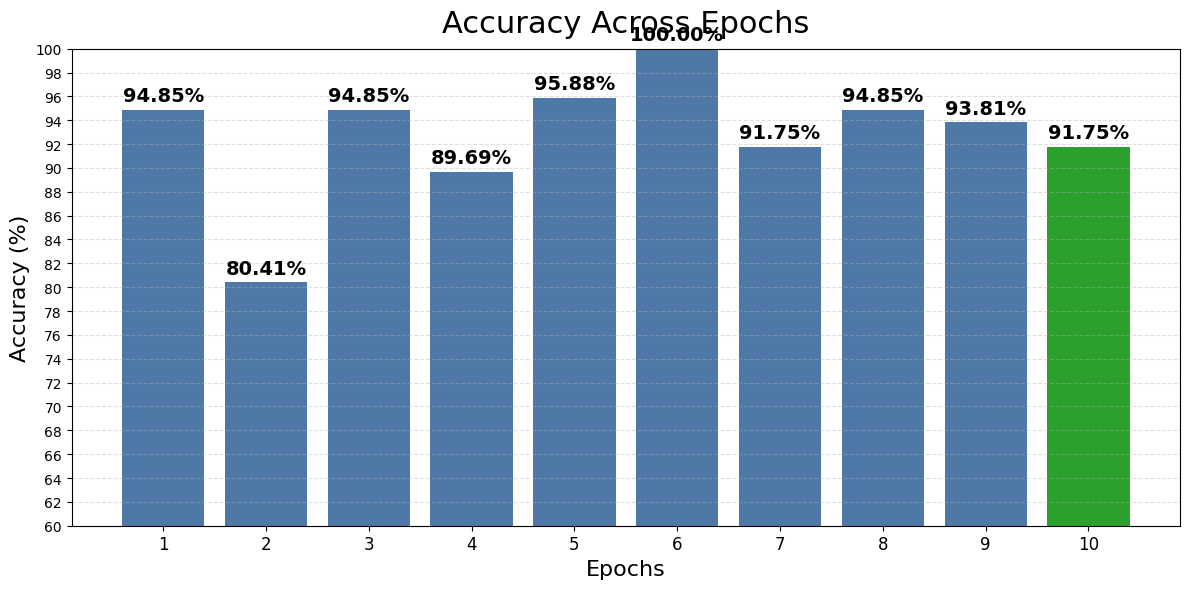

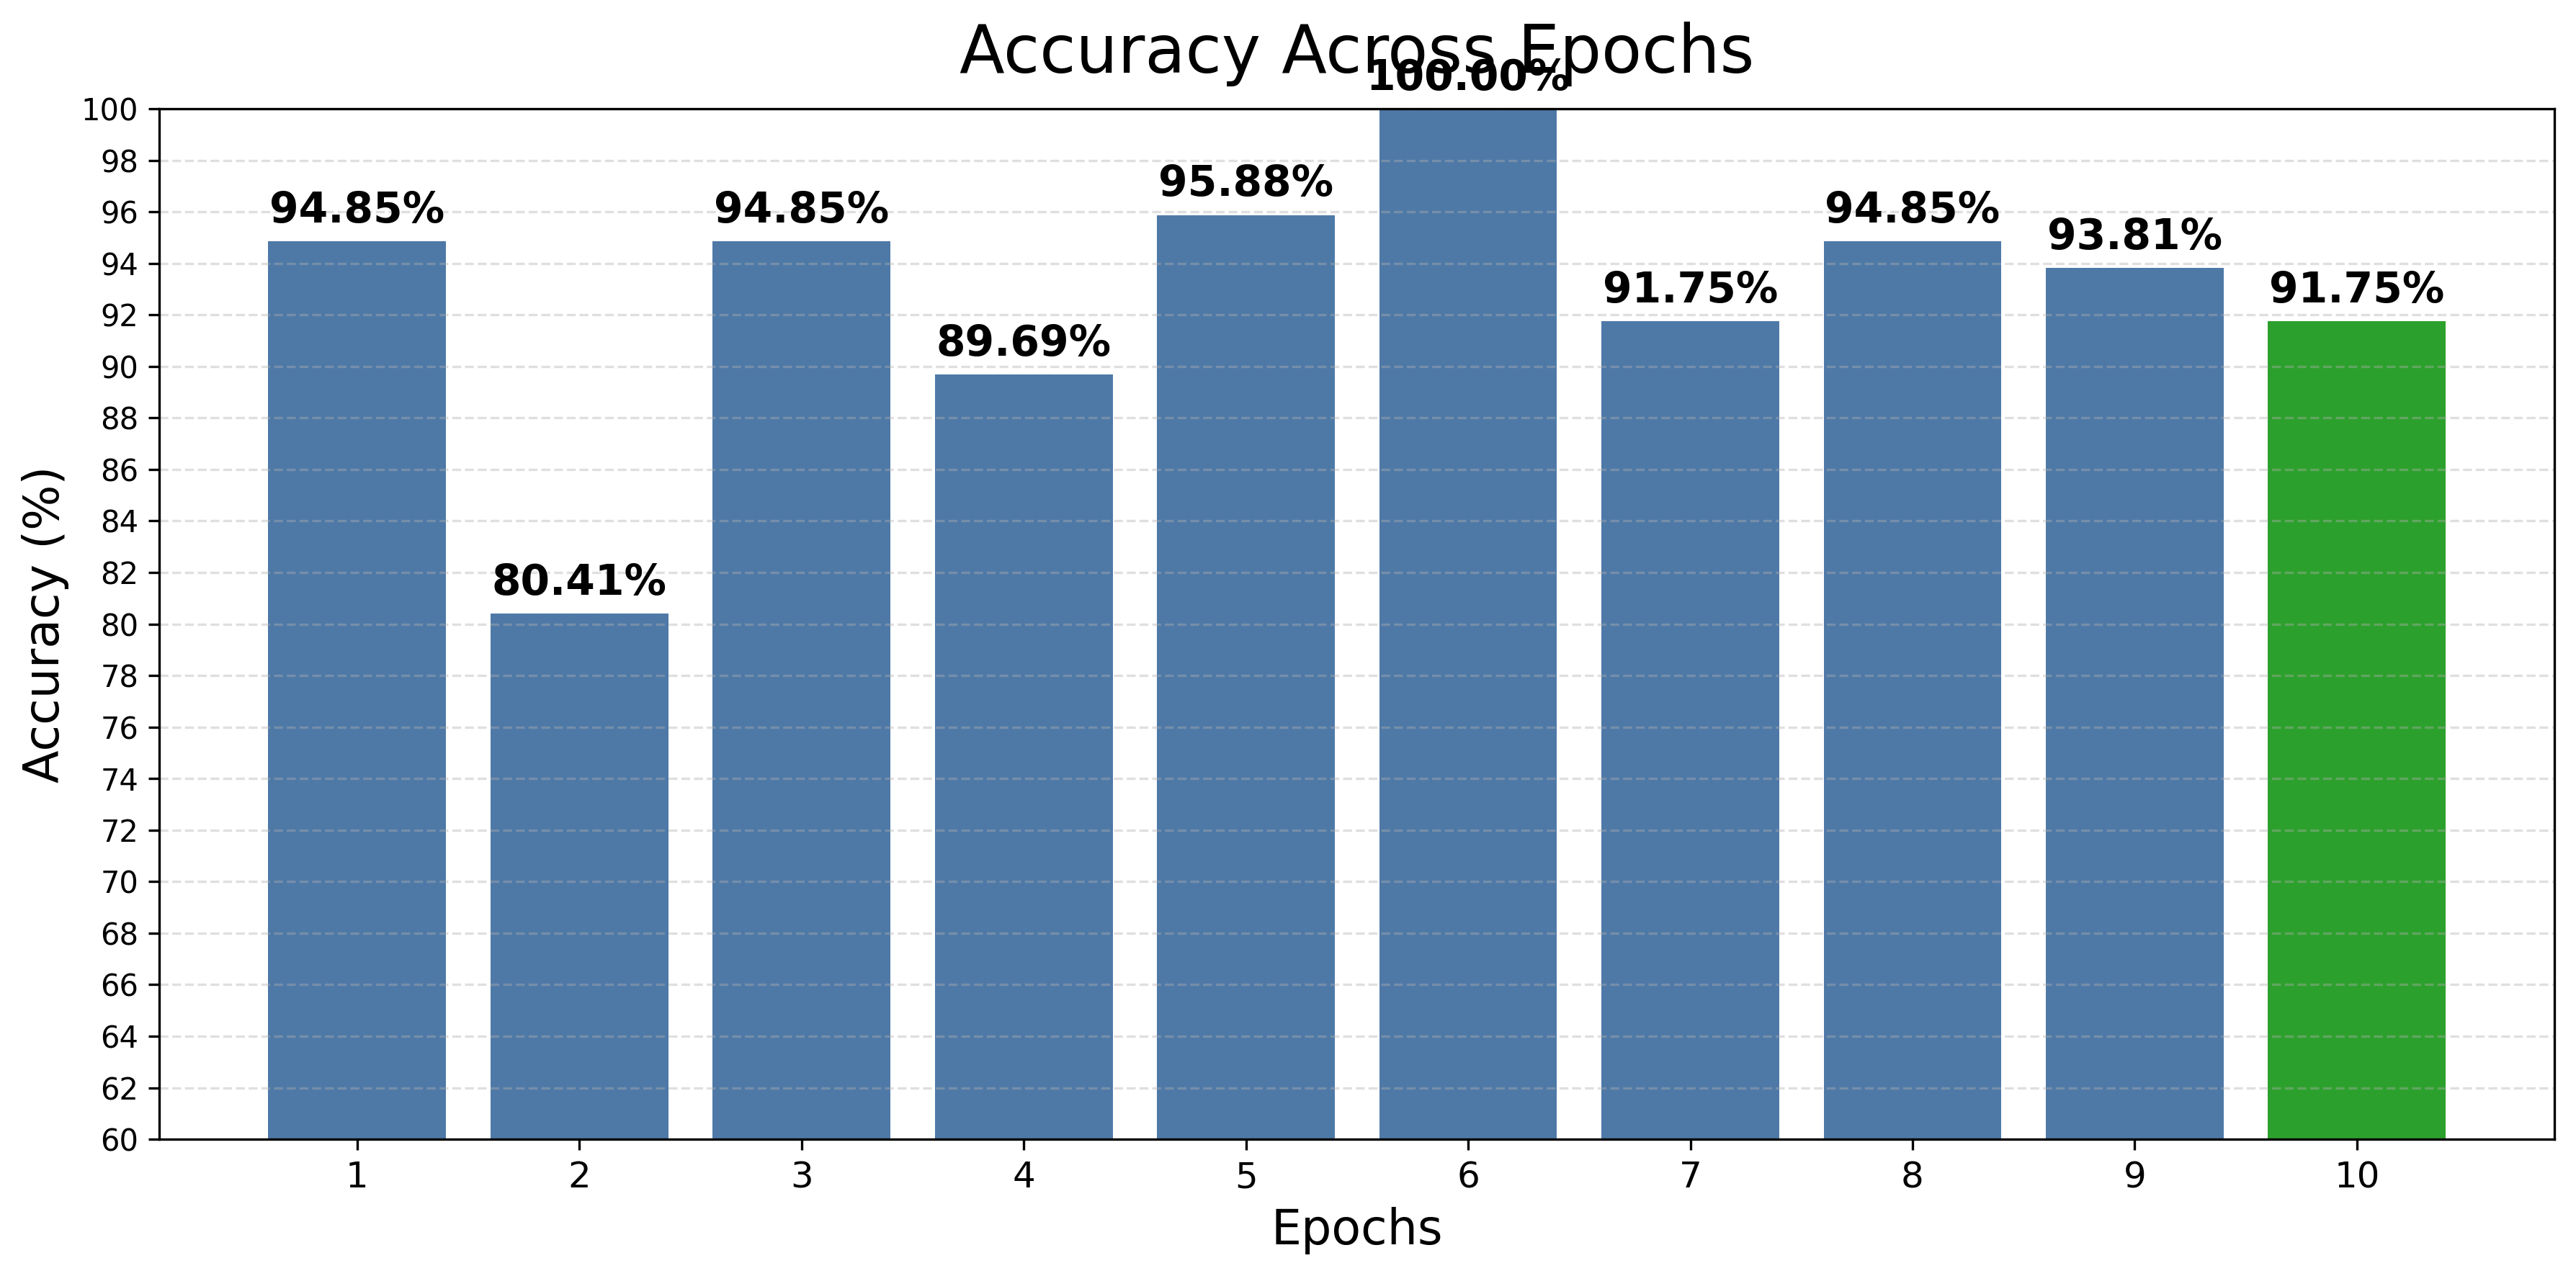

Saved: /content/drive/MyDrive/HSI_RESULTS/precision_across_epochs.png


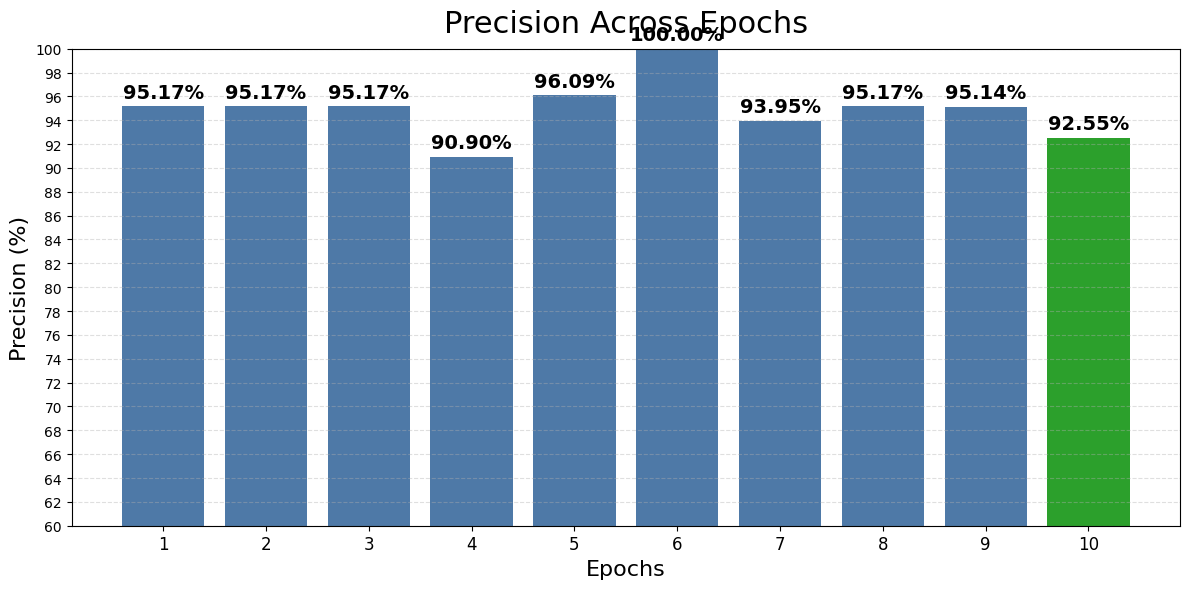

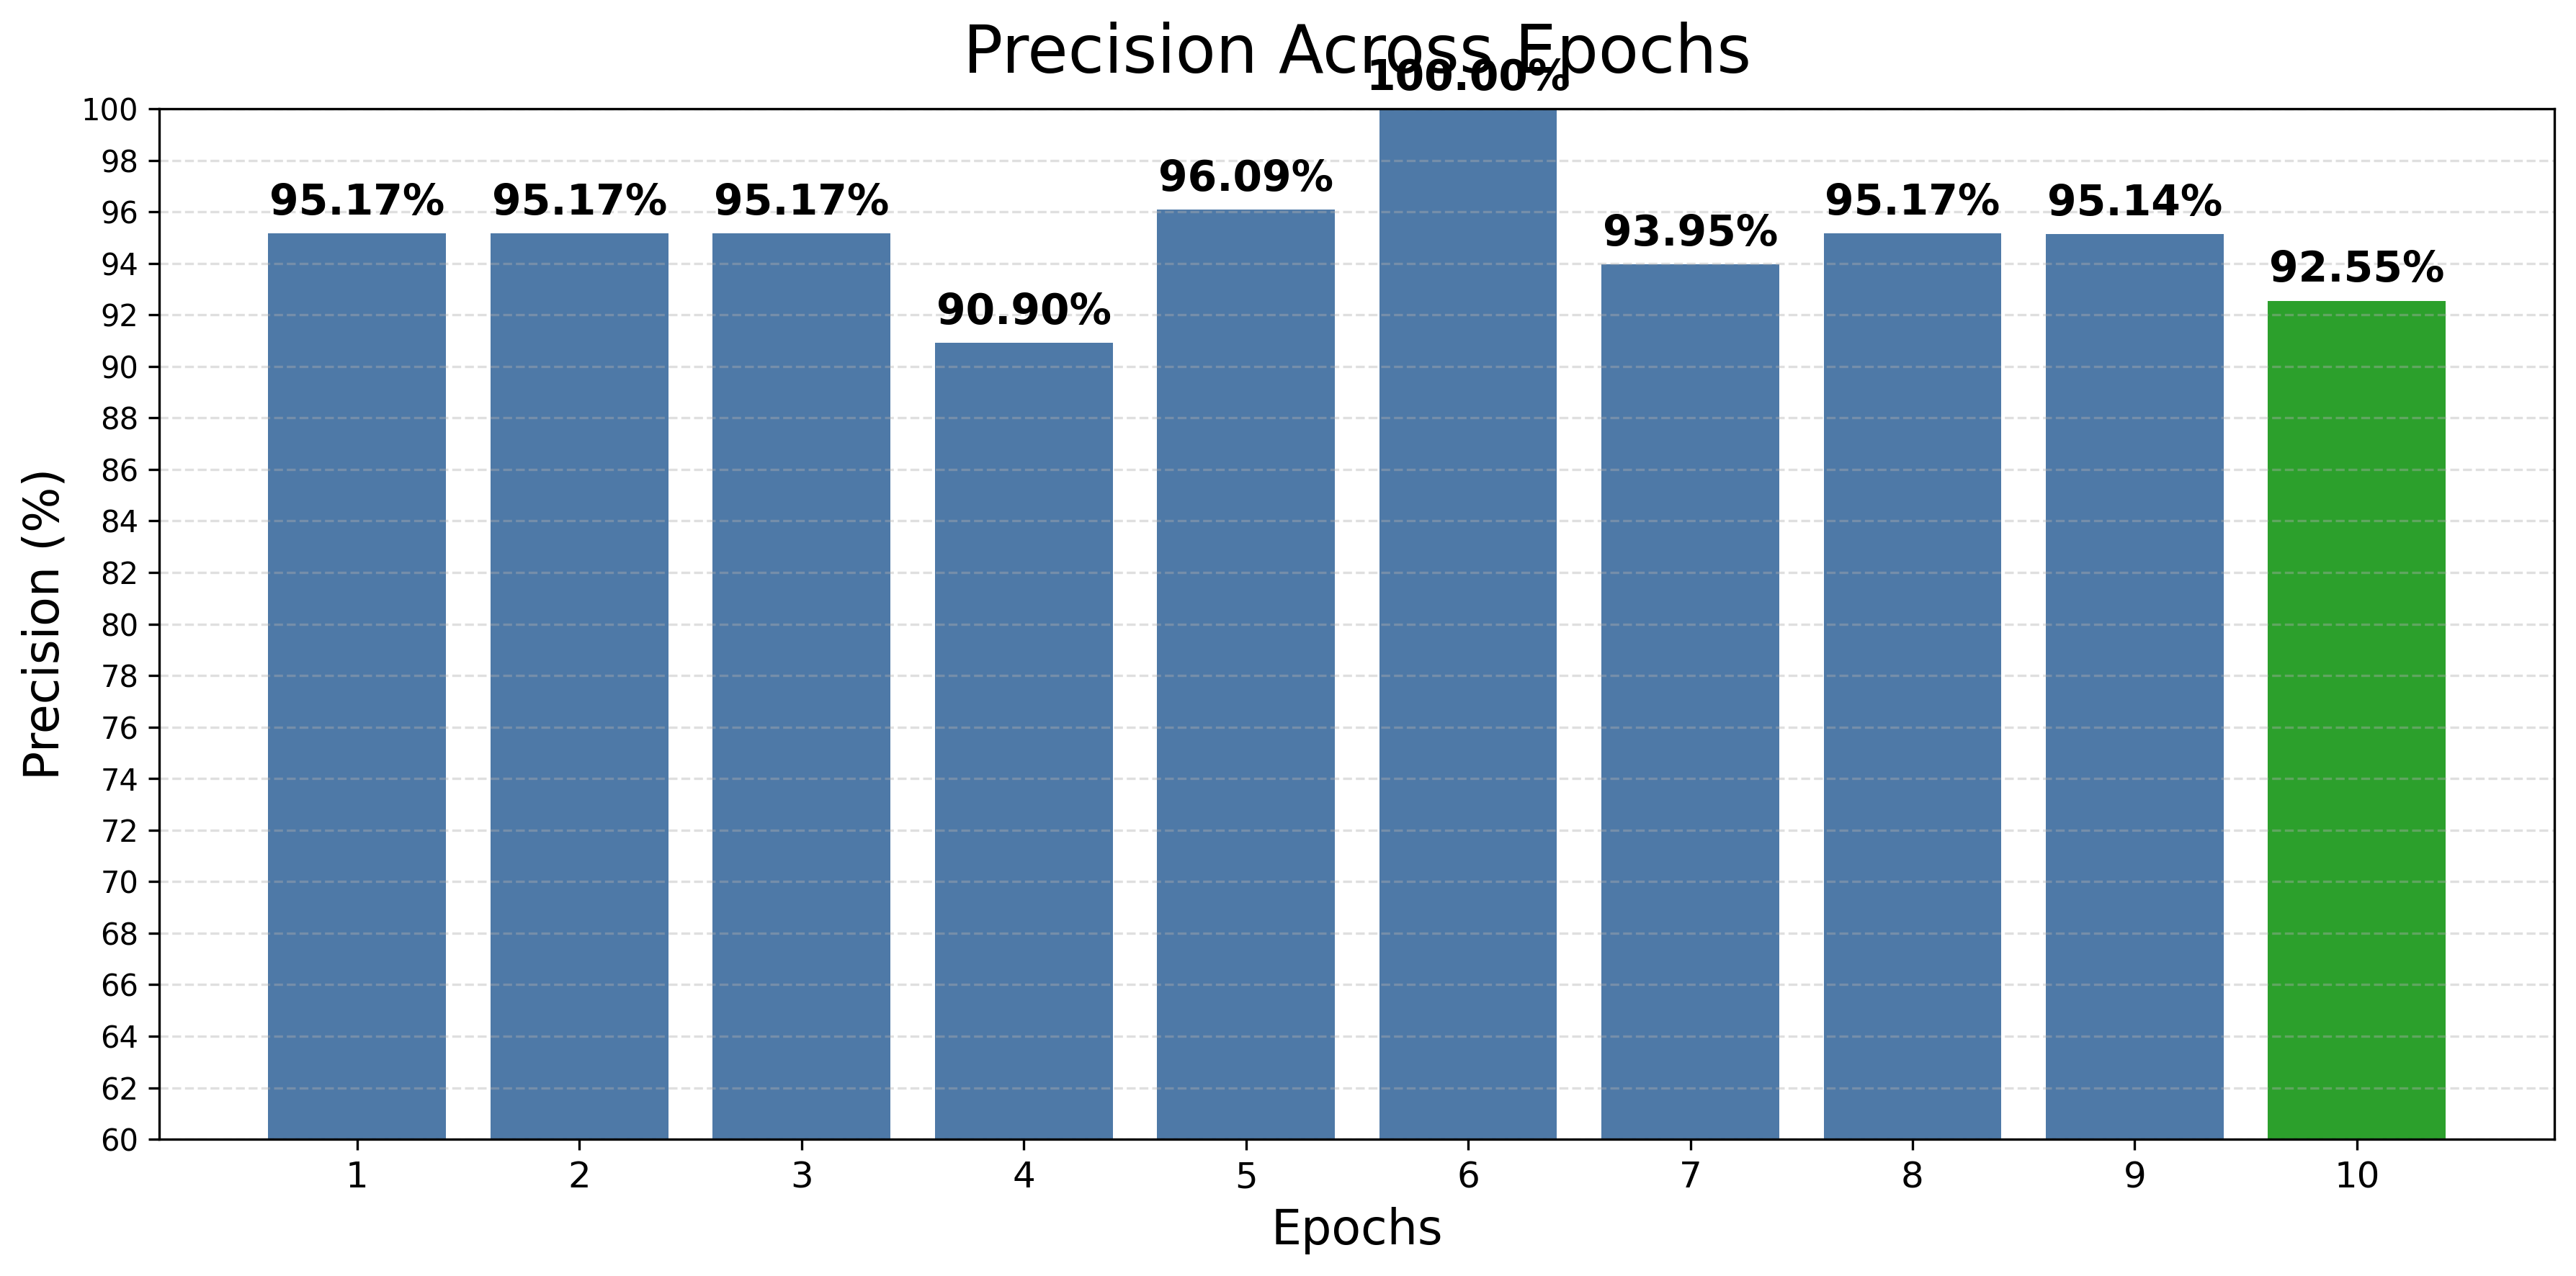

Saved: /content/drive/MyDrive/HSI_RESULTS/recall_across_epochs.png


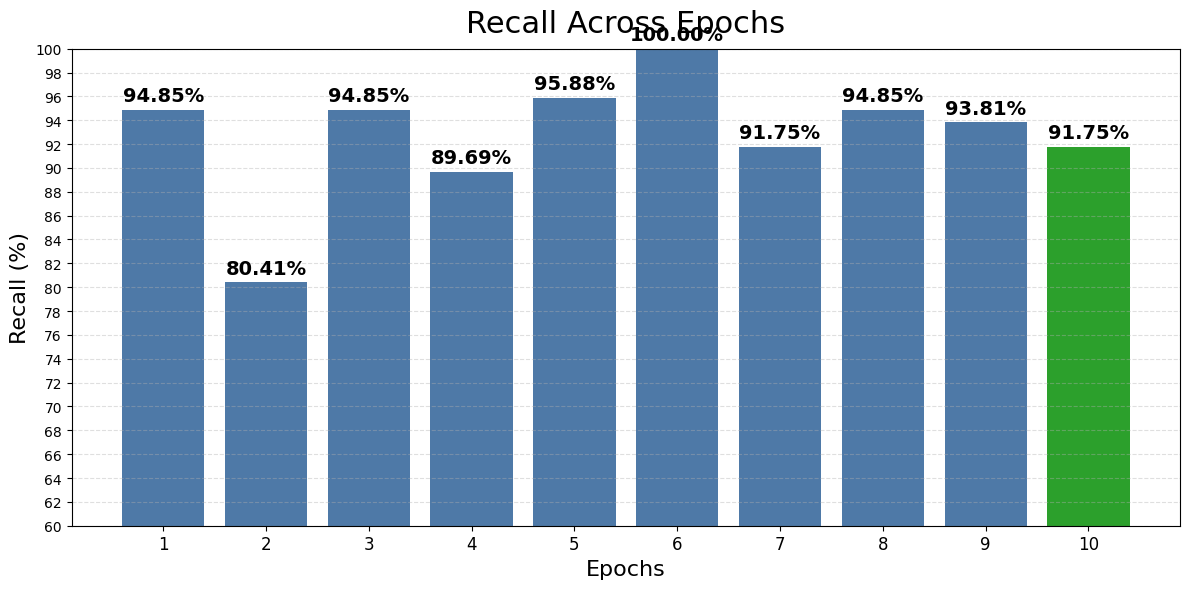

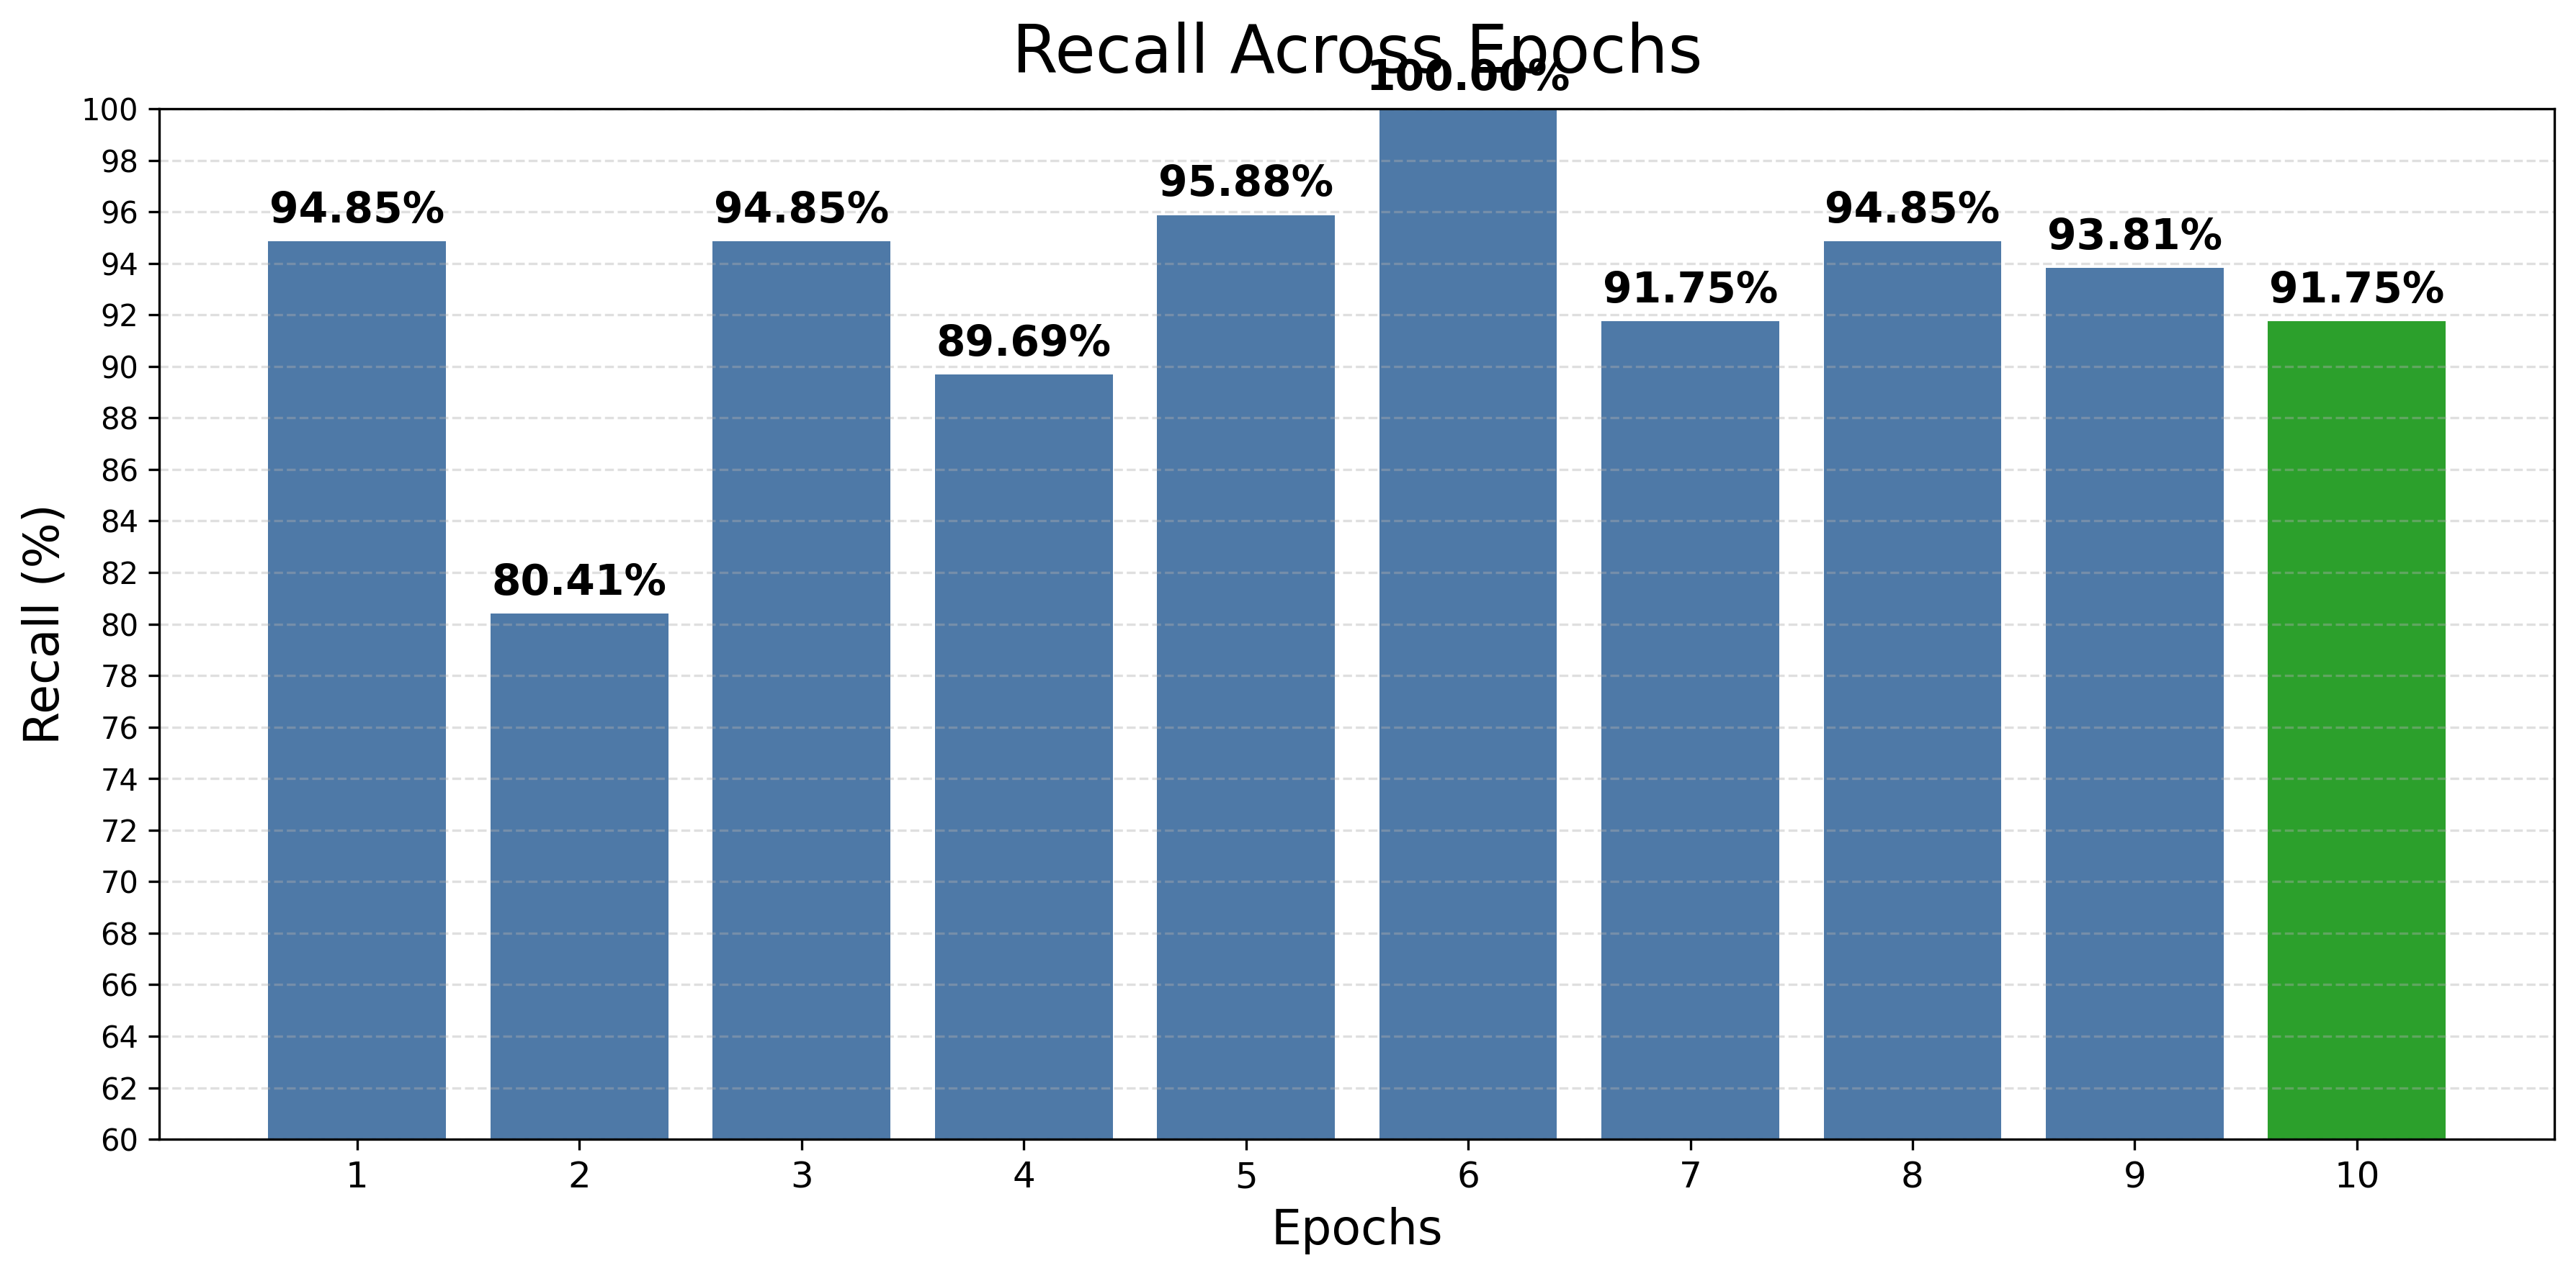

Saved: /content/drive/MyDrive/HSI_RESULTS/f1_across_epochs.png


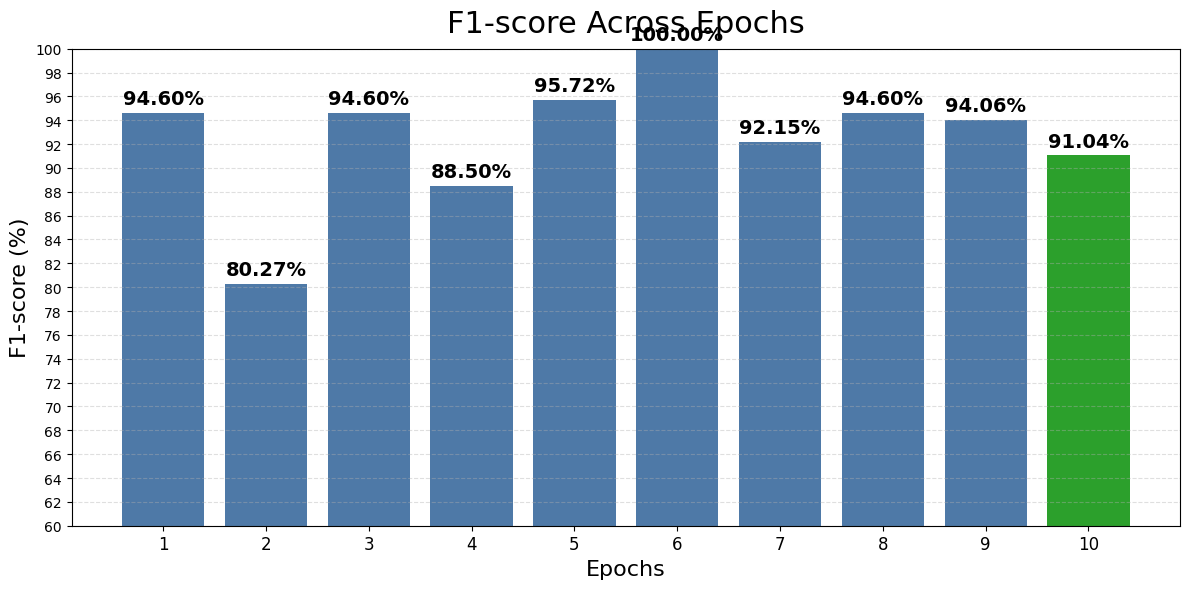

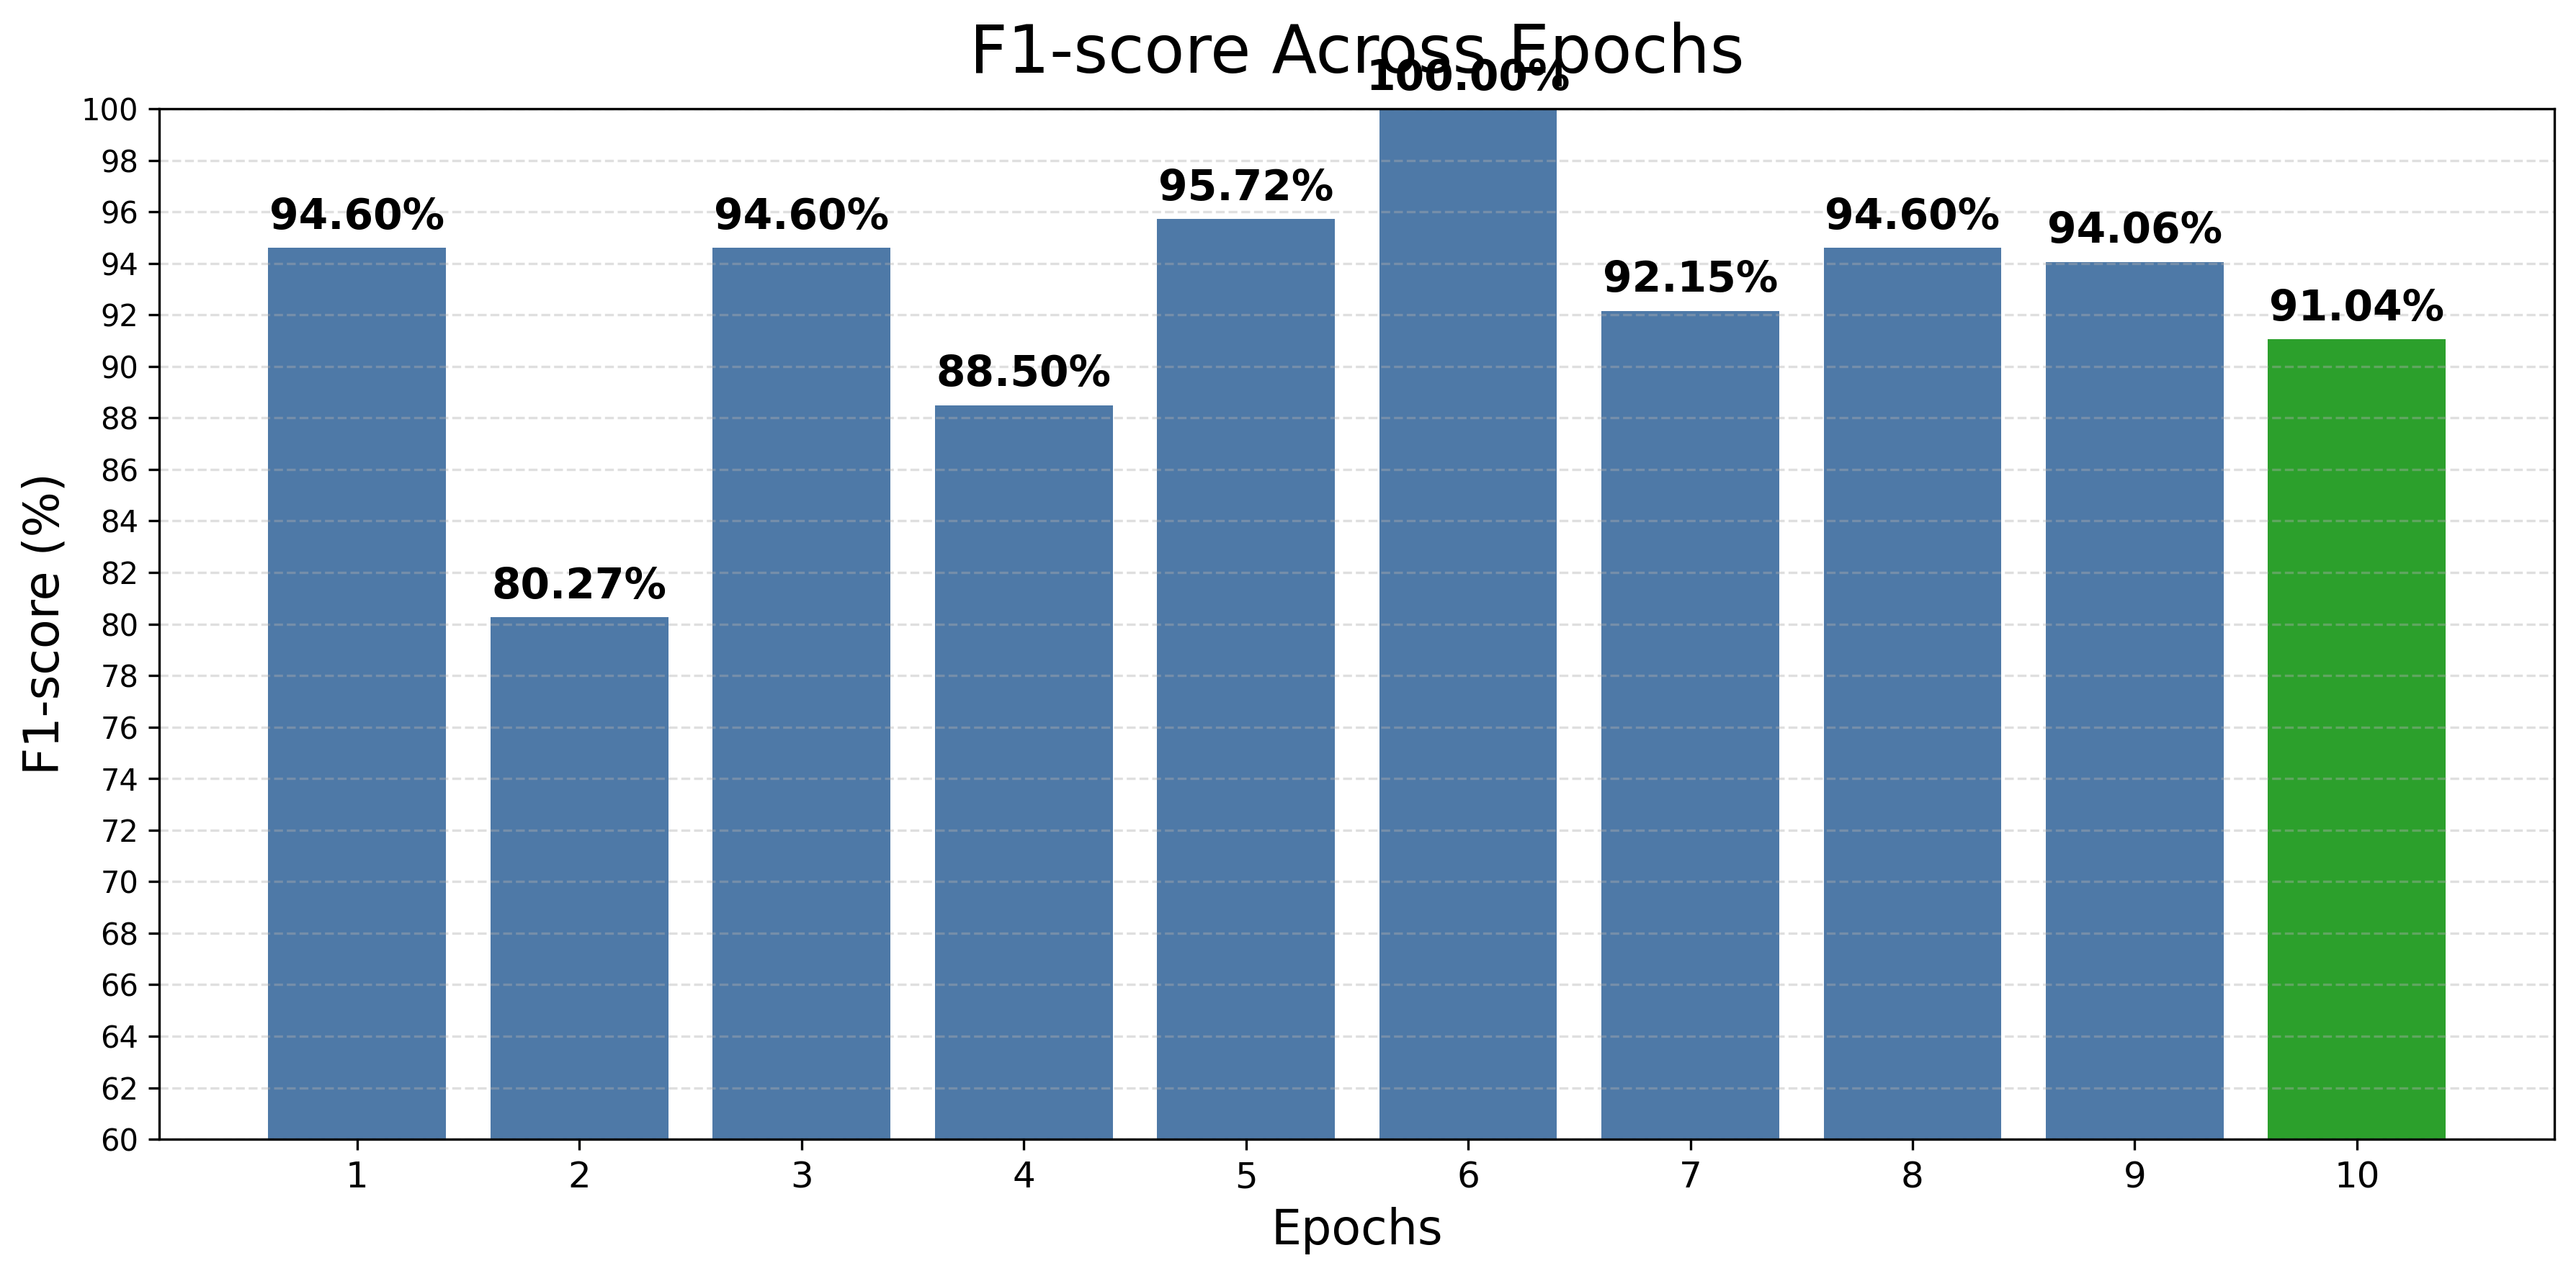


Done. Metric lists available as: val_accs, val_precs, val_recalls, val_f1s


In [ ]:
# ============================================
# FINAL: Build & Plot Metrics Across Epochs
# from saved checkpoints (no retraining)
# ============================================
import os, re, torch, numpy as np, matplotlib.pyplot as plt
from glob import glob
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from IPython.display import display, Image
from tqdm import tqdm

# --- Point to your results folder (as in your screenshot) ---
SAVE_DIR = "/content/drive/MyDrive/HSI_RESULTS"
print("Using SAVE_DIR:", SAVE_DIR)

# --- Averaging & plotting config ---
AVERAGE  = "weighted"   # to match your training prints
ZERO_DIV = 0            # safe for undefined precision/recall
YLIM     = (60, 100)    # adjust if needed

# --- Helper: nice bar chart like your examples ---
def plot_metric_across_epochs(values, title, ylabel, ylim=(85, 100), save_name=None, also_show_saved=True):
    epochs = np.arange(1, len(values) + 1)
    plt.figure(figsize=(12, 6))
    colors = ['#4e79a7'] * len(values)
    if len(values): colors[-1] = '#2ca02c'  # highlight final epoch
    bars = plt.bar(epochs, values, color=colors)
    plt.title(title, fontsize=22, pad=12)
    plt.xlabel("Epochs", fontsize=16); plt.ylabel(ylabel, fontsize=16)
    if ylim:
        plt.ylim(*ylim)
        try: plt.yticks(np.arange(ylim[0], ylim[1] + 0.1, 2))
        except: pass
    plt.xticks(epochs, [str(e) for e in epochs], fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    bump = (ylim[1]-ylim[0])*0.01 if ylim else 0.2
    for b, v in zip(bars, values):
        plt.text(b.get_x()+b.get_width()/2, b.get_height()+bump,
                 f"{v:.2f}%", ha='center', va='bottom', fontsize=14, fontweight='bold')
    plt.tight_layout()
    out_path = None
    if save_name:
        os.makedirs(SAVE_DIR, exist_ok=True)
        out_path = os.path.join(SAVE_DIR, save_name)
        plt.savefig(out_path, dpi=300, bbox_inches='tight')
        print("Saved:", out_path)
    plt.show()
    if also_show_saved and out_path:
        display(Image(filename=out_path))

# --- Find checkpoints and sort by epoch ---
ckpts = glob(os.path.join(SAVE_DIR, "checkpoint_epoch*_*.pth"))
def _epoch_num(path):
    m = re.search(r"checkpoint_epoch(\d+)", os.path.basename(path))
    return int(m.group(1)) if m else 0
ckpts = sorted(ckpts, key=_epoch_num)

if not ckpts:
    raise RuntimeError(f"No checkpoints found in {SAVE_DIR}.")

# --- Ensure model & val_loader exist (created in your training cell) ---
if 'model' not in globals():
    model = UNet3D().to(device)  # uses your class definition
model.eval()

# --- Evaluate each checkpoint on the current val_loader ---
val_accs, val_precs, val_recalls, val_f1s = [], [], [], []
epochs_seen, saved_f1s, saved_losses = [], [], []

for ck in tqdm(ckpts, desc="Evaluating checkpoints"):
    state = torch.load(ck, map_location=device)
    try:
        model.load_state_dict(state['model_state'])
        epochs_seen.append(state.get('epoch', _epoch_num(ck)))
        saved_f1s.append(state.get('f1'))
        saved_losses.append(state.get('loss'))
    except Exception:
        model.load_state_dict(state)
        epochs_seen.append(_epoch_num(ck))
        saved_f1s.append(None); saved_losses.append(None)

    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            preds = model(imgs).argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    acc = accuracy_score(y_true, y_pred) * 100
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=AVERAGE, zero_division=ZERO_DIV
    )
    val_accs.append(acc)
    val_precs.append(p * 100)
    val_recalls.append(r * 100)
    val_f1s.append(f1 * 100)

print("\nEpochs evaluated:", epochs_seen)
print("Acc:", [f"{v:.2f}" for v in val_accs])
print("Pre:", [f"{v:.2f}" for v in val_precs])
print("Rec:", [f"{v:.2f}" for v in val_recalls])
print("F1 :", [f"{v:.2f}" for v in val_f1s])

# --- Plot & save charts (final epoch highlighted) ---
plot_metric_across_epochs(val_accs,   "Accuracy Across Epochs",  "Accuracy (%)",  ylim=YLIM, save_name="accuracy_across_epochs.png")
plot_metric_across_epochs(val_precs,  "Precision Across Epochs", "Precision (%)", ylim=YLIM, save_name="precision_across_epochs.png")
plot_metric_across_epochs(val_recalls,"Recall Across Epochs",    "Recall (%)",    ylim=YLIM, save_name="recall_across_epochs.png")
plot_metric_across_epochs(val_f1s,    "F1-score Across Epochs",  "F1-score (%)",  ylim=YLIM, save_name="f1_across_epochs.png")

print("\nDone. Metric lists available as: val_accs, val_precs, val_recalls, val_f1s")


In [ ]:
#resizing
from sklearn.decomposition import PCA

def snv_normalize_cube(hsi_cube):

    H, W, B = hsi_cube.shape

    spectra = hsi_cube.reshape(-1, B)
    mean = spectra.mean(axis=1, keepdims=True)
    std = spectra.std(axis=1, keepdims=True) + 1e-8
    snv_spectra = (spectra - mean) / std

    return snv_spectra.reshape(H, W, B)


def pca_reduce_cube(hsi_cube, n_components=10):

    H, W, B = hsi_cube.shape
    spectra = hsi_cube.reshape(-1, B)

    pca = PCA(n_components=n_components, random_state=42)
    pca_output = pca.fit_transform(spectra)

    return pca_output.reshape(H, W, n_components), pca




In [ ]:
import torch
import numpy as np
import torch.nn.functional as F

# DEFINE DEVICE AGAIN (fixes the NameError)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✔ Using device:", device)

# Correct model path
MODEL_PATH = "/content/drive/MyDrive/HSI_RESULTS/best_unet_hsi.pth"
print("📁 Model Path:", MODEL_PATH)

# Recreate UNet3D and load weights
inference_model = UNet3D(n_classes=4).to(device)
state_dict = torch.load(MODEL_PATH, map_location=device)
inference_model.load_state_dict(state_dict)
inference_model.eval()

print("✅ Model loaded successfully!")

stages = ["Stage I", "Stage II", "Stage III", "Stage IV"]


✔ Using device: cpu
📁 Model Path: /content/drive/MyDrive/HSI_RESULTS/best_unet_hsi.pth
✅ Model loaded successfully!


In [ ]:
!pip install -q gradio


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✔ Using device:", device)

# Path to your saved weights
MODEL_PATH = "/content/drive/MyDrive/HSI_RESULTS/best_unet_hsi.pth"

# Recreate your UNet3D architecture
class DoubleConv3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv3D, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    def __init__(self, n_classes=4):
        super(UNet3D, self).__init__()
        self.enc1 = DoubleConv3D(1, 16)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = DoubleConv3D(16, 32)
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = DoubleConv3D(32, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv3D(64, 32)
        self.up2 = nn.ConvTranspose3d(32, 16, 2, stride=2)
        self.dec2 = DoubleConv3D(32, 16)
        self.out_conv = nn.Conv3d(16, n_classes, 1)
        self.global_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Linear(n_classes, n_classes)

    def forward(self, x):
        def crop_or_pad(tensor, target_shape):
            _, _, d, h, w = tensor.shape
            td, th, tw = target_shape
            d1 = max((d - td) // 2, 0)
            h1 = max((h - th) // 2, 0)
            w1 = max((w - tw) // 2, 0)
            return tensor[:, :, d1:d1+td, h1:h1+th, w1:w1+tw]

        c1 = self.enc1(x)
        p1 = self.pool1(c1)
        c2 = self.enc2(p1)
        p2 = self.pool2(c2)
        c3 = self.enc3(p2)
        u1 = self.up1(c3)
        if u1.shape[2:] != c2.shape[2:]:
            c2 = crop_or_pad(c2, u1.shape[2:])
        u1 = torch.cat([u1, c2], dim=1)
        d1 = self.dec1(u1)
        u2 = self.up2(d1)
        if u2.shape[2:] != c1.shape[2:]:
            c1 = crop_or_pad(c1, u2.shape[2:])
        u2 = torch.cat([u2, c1], dim=1)
        d2 = self.dec2(u2)
        out = self.out_conv(d2)
        pooled = self.global_pool(out).squeeze(-1).squeeze(-1).squeeze(-1)
        return self.fc(pooled)

import torch.nn as nn
inference_model = UNet3D(n_classes=4).to(device)
state_dict = torch.load(MODEL_PATH, map_location=device)
inference_model.load_state_dict(state_dict)
inference_model.eval()
print("✅ Model loaded from:", MODEL_PATH)

stages = ["Stage I", "Stage II", "Stage III", "Stage IV"]


✔ Using device: cpu
✅ Model loaded from: /content/drive/MyDrive/HSI_RESULTS/best_unet_hsi.pth


In [ ]:
# =====================================================================
# Melanoma Stage App – Single .bmp Image Demo (NO TRAINING REQUIRED)
# =====================================================================

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gradio as gr

# ------------------ 1. Device & Paths ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# Use the same paths as in your training code
DATA_DIR = "/content/drive/MyDrive/HSIDERMA/original_image/MM"
SAVE_DIR = "/content/drive/MyDrive/HSI_RESULTS"
MODEL_PATH = os.path.join(SAVE_DIR, "best_unet_hsi.pth")

print("📁 MODEL_PATH:", MODEL_PATH)

# ------------------ 2. Infer NUM_BANDS from your HSI dataset ------------------
bmp_files = [f for f in os.listdir(DATA_DIR) if f.endswith(".bmp")]
if len(bmp_files) == 0:
    raise RuntimeError(f"No .bmp files found in DATA_DIR: {DATA_DIR}")
NUM_BANDS = len(bmp_files)
print("🔢 Estimated spectral bands used during training (NUM_BANDS):", NUM_BANDS)

# ------------------ 3. Rebuild your UNet3D architecture ------------------
class DoubleConv3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv3D, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)


class UNet3D(nn.Module):
    def __init__(self, n_classes=4):
        super(UNet3D, self).__init__()
        self.enc1 = DoubleConv3D(1, 16)
        self.pool1 = nn.MaxPool3d(2)

        self.enc2 = DoubleConv3D(16, 32)
        self.pool2 = nn.MaxPool3d(2)

        self.enc3 = DoubleConv3D(32, 64)

        self.up1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv3D(64, 32)

        self.up2 = nn.ConvTranspose3d(32, 16, 2, stride=2)
        self.dec2 = DoubleConv3D(32, 16)

        self.out_conv = nn.Conv3d(16, n_classes, 1)

        self.global_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Linear(n_classes, n_classes)

    def forward(self, x):
        def crop_or_pad(tensor, target_shape):
            _, _, d, h, w = tensor.shape
            td, th, tw = target_shape
            d1 = max((d - td) // 2, 0)
            h1 = max((h - th) // 2, 0)
            w1 = max((w - tw) // 2, 0)
            return tensor[:, :, d1:d1+td, h1:h1+th, w1:w1+tw]

        c1 = self.enc1(x)
        p1 = self.pool1(c1)

        c2 = self.enc2(p1)
        p2 = self.pool2(c2)

        c3 = self.enc3(p2)

        u1 = self.up1(c3)
        if u1.shape[2:] != c2.shape[2:]:
            c2 = crop_or_pad(c2, u1.shape[2:])
        u1 = torch.cat([u1, c2], dim=1)
        d1 = self.dec1(u1)

        u2 = self.up2(d1)
        if u2.shape[2:] != c1.shape[2:]:
            c1 = crop_or_pad(c1, u2.shape[2:])
        u2 = torch.cat([u2, c1], dim=1)
        d2 = self.dec2(u2)

        out = self.out_conv(d2)
        pooled = self.global_pool(out).squeeze(-1).squeeze(-1).squeeze(-1)
        return self.fc(pooled)

# ------------------ 4. Load trained weights ------------------
stages = ["Stage I", "Stage II", "Stage III", "Stage IV"]

inference_model = UNet3D(n_classes=4).to(device)
state_dict = torch.load(MODEL_PATH, map_location=device)
inference_model.load_state_dict(state_dict)
inference_model.eval()
print("✅ Loaded trained model weights.")

# ------------------ 5. Preprocessing single .bmp as pseudo-HSI ------------------
PATCH_SIZE = 64  # same patch size as during training

def preprocess_single_bmp(img: np.ndarray,
                          patch_size: int = PATCH_SIZE,
                          num_bands: int = NUM_BANDS) -> torch.Tensor:
    """
    img: numpy array from Gradio (H,W) or (H,W,3/4)

    Steps:
      - convert to grayscale if RGB
      - normalize to 0–1
      - center-crop to 64×64
      - repeat that patch along spectral dimension to create [64,64,num_bands]
      - reshape to [1,1,64,64,num_bands] for 3D U-Net
    """
    # 1) Convert to grayscale if needed
    if img.ndim == 3:
        img_gray = img.mean(axis=2)
    else:
        img_gray = img

    img_gray = img_gray.astype(np.float32)

    # 2) Normalize like in training
    if img_gray.max() > 1.5:
        img_gray = img_gray / 255.0

    H, W = img_gray.shape
    if H < patch_size or W < patch_size:
        raise ValueError(f"Image too small ({H}x{W}). Need at least {patch_size}x{patch_size}.")

    # 3) Center crop 64x64
    top = (H - patch_size) // 2
    left = (W - patch_size) // 2
    patch = img_gray[top:top+patch_size, left:left+patch_size]   # [64,64]

    # 4) Fake a spectral cube: repeat along "band" dimension
    #    [64,64] -> [64,64,num_bands]
    patch_cube = np.repeat(patch[:, :, None], num_bands, axis=2)

    # 5) Add batch + channel dims -> [1,1,64,64,num_bands]
    patch_cube = np.expand_dims(patch_cube, 0)   # [1,64,64,num_bands]
    patch_cube = np.expand_dims(patch_cube, 0)   # [1,1,64,64,num_bands]

    tensor = torch.tensor(patch_cube, dtype=torch.float32, device=device)
    return tensor

# ------------------ 6. Prediction function used by Gradio ------------------
def predict_from_single_image(img: np.ndarray) -> str:
    """
    img: numpy array from Gradio Image input.
    Returns markdown text with prediction + probabilities.
    """
    try:
        x = preprocess_single_bmp(img)   # [1,1,64,64,NUM_BANDS]

        with torch.no_grad():
            logits = inference_model(x)  # [1,4]
            probs = F.softmax(logits, dim=1).cpu().numpy()[0]
            pred_class = int(np.argmax(probs))

        label = stages[pred_class]

        lines = [f"### 🩺 Predicted Melanoma Stage: **{label}**", ""]
        lines.append("#### Class Probabilities:")
        for s, p in zip(stages, probs):
            lines.append(f"- **{s}** → `{p:.3f}`")
        lines.append("")
        lines.append("> ⚠️ Research prototype demo. Model was originally trained on full HSI cubes, "
                     "here a single image is replicated across spectral bands for demonstration.")
        return "\n".join(lines)

    except Exception as e:
        return f"❌ Error: {e}"

# ------------------ 7. Gradio App ------------------
demo = gr.Interface(
    fn=predict_from_single_image,
    inputs=gr.Image(type="numpy", label="Upload lesion image (.bmp, .png, .jpg, etc.)"),
    outputs=gr.Markdown(label="Prediction"),
    title="Melanoma Stage Detection – Single Image Demo (3D U-Net)",
    description=(
        "Upload a single lesion image (e.g., `.bmp`). The app crops a 64×64 center patch and "
        "replicates it across spectral bands to simulate an HSI cube, then predicts melanoma stage.\n\n"
        "**Note:** This is a research/educational demo. The real model was trained on true hyperspectral data."
    ),
)

demo.launch()


✅ Using device: cpu
📁 MODEL_PATH: /content/drive/MyDrive/HSI_RESULTS/best_unet_hsi.pth
🔢 Estimated spectral bands used during training (NUM_BANDS): 85
✅ Loaded trained model weights.
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b4f2040f860fd3cf7d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
